In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import cross_validation
from sklearn import tree as Tree
import sklearn.tree
%matplotlib inline 

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Load in data

In [3]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/80_20_processed_data/master_8020_df.csv',index_col=0)

In [4]:
data.iloc[0,:]

Previous_10_Left_Choice     10.000
Previous_10_Right_Choice     0.000
Previous_10_Left_Reward      8.000
Previous_10_Right_Reward     0.000
Streak                      -1.000
5_Port                       1.000
5_Reward                     0.000
5_ITI                        3.286
5_trialDuration              0.407
4_Port                       1.000
4_Reward                     1.000
4_ITI                        2.405
4_trialDuration              0.463
3_Port                       1.000
3_Reward                     1.000
3_ITI                        2.379
3_trialDuration              0.367
2_Port                       1.000
2_Reward                     1.000
2_ITI                        2.234
2_trialDuration              0.325
1_Port                       1.000
1_Reward                     0.000
1_ITI                        2.133
1_trialDuration              0.482
0_ITI                        1.411
0_trialDuration              0.435
Decision                     1.000
Name: 0, dtype: floa

## Set the 'outcome' features, 'timing' features, and get the column indices for both

In [5]:
outcome_features = ['Streak','5_Reward','4_Reward','3_Reward','2_Reward','1_Reward']
timing_features = ['5_ITI','5_trialDuration','4_ITI','4_trialDuration','3_ITI','3_trialDuration',
                   '2_ITI','2_trialDuration','1_ITI','1_trialDuration']

In [6]:
#get column indices (so we can index from the numpy arrays)
outcome_inds = []
timing_inds = []
for f in outcome_features:
    outcome_inds.append(data.columns.get_loc(f))
    
for f in timing_features:
    timing_inds.append(data.columns.get_loc(f))

## Extract 'x' and 'y'

In [7]:
#extract features and decisions
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

# Change 'y' so that 1 corresponds to a switch, and 0 corresponds to no switch

In [8]:
y_diff = np.diff(y)
x = x[1:,:]
y = np.abs(y_diff.copy())

print(x.shape)
print(y_diff.shape)

(11325, 27)
(11325,)


In [9]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [10]:
print('# train trials: %.0f | # switches: %.0f --> %.01f percent' % (y_train.shape[0],np.sum(y_train),np.sum(y_train)*100.0/y_train.shape[0]))
print('# test trials: %.0f | # switches: %.0f --> %.01f percent' % (y_test.shape[0],np.sum(y_test),np.sum(y_test)*100.0/y_test.shape[0]))

# train trials: 7927 | # switches: 661 --> 8.3 percent
# test trials: 3398 | # switches: 236 --> 6.9 percent


# LDA with priors tuned in ```predict_switches```

In [11]:
'''
LDA
'''
lda_outcome = discriminant_analysis.LinearDiscriminantAnalysis(priors = [0.4,0.6])
lda_timing = discriminant_analysis.LinearDiscriminantAnalysis(priors = [0.4,0.6])
lda_both = discriminant_analysis.LinearDiscriminantAnalysis(priors = [0.4,0.6])

lda_outcome.fit(x_train[:,outcome_inds],y_train)
lda_timing.fit(x_train[:,timing_inds],y_train)
lda_both.fit(x_train,y_train)

y_pred_outcome = lda_outcome.predict(x_test[:,outcome_inds])
y_pred_timing = lda_timing.predict(x_test[:,timing_inds])
y_pred_both = lda_both.predict(x_test)

//anaconda/envs/ac209/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [12]:
print('Outcome features:')
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_pred_outcome,y_test,disp=True,confusion=False)

print('Timing features:')
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_pred_timing,y_test,disp=True,confusion=False)

print('All features:')
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_pred_both,y_test,disp=True,confusion=False)

Outcome features:
          Predicted NO  Predicted YES
True NO         2416.0          746.0
True YES          24.0          212.0

F1: 0.355

Accuracy on class 0: 0.76
Accuracy on class 1: 0.90

Timing features:
          Predicted NO  Predicted YES
True NO          649.0         2513.0
True YES          21.0          215.0

F1: 0.145

Accuracy on class 0: 0.21
Accuracy on class 1: 0.91

All features:
          Predicted NO  Predicted YES
True NO         2473.0          689.0
True YES          21.0          215.0

F1: 0.377

Accuracy on class 0: 0.78
Accuracy on class 1: 0.91



That's interesting. It's as if, with only the timing features, maybe the prior tuning is actually off (since the accuracy on the two classes are very different!). 

### What if we parameter tune using only the timing features:

In [13]:
# set x_train to only include the timing features
x_train_t = x_train[:,timing_inds]

'''
LDA
'''
P = np.arange(0,1,0.01)

acc_cv = []

for i,p in enumerate(P):
    prior = np.array([1.0-p,p])
    lda = discriminant_analysis.LinearDiscriminantAnalysis(priors = prior)
    
    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0
    
    for train_index,test_index in kf:
        x_train_cv = x_train_t[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train_t[test_index,:]
        y_test_cv = y_train[test_index]

        lda.fit(x_train_cv,y_train_cv)
        y_predict = lda.predict(x_test_cv)
        
        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)
        
        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

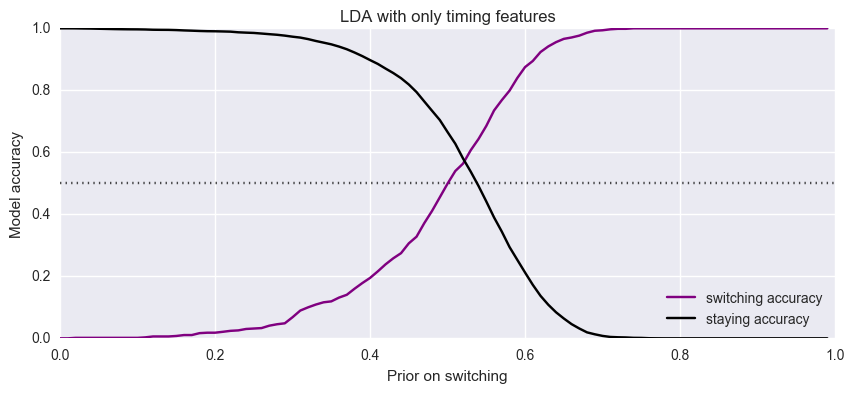

In [14]:
plt.figure(figsize=(10,4))
plt.plot(P,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(P,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
plt.legend(loc='lower right',bbox_to_anchor=[1,0])
plt.xlim(0,1)
plt.xlabel('Prior on switching')
plt.ylabel('Model accuracy')
plt.title('LDA with only timing features')

This seems to do quite worse than the model that included all features. So maybe previous reward outcome is (like we would expect) what is important! Let's tune again for just the outcome featuers:

### Tuning with only outcome features

In [15]:
# set x_train to only include the timing features
x_train_o = x_train[:,outcome_inds]

'''
LDA
'''
P = np.arange(0,1,0.01)

acc_cv = []

for i,p in enumerate(P):
    prior = np.array([1.0-p,p])
    lda = discriminant_analysis.LinearDiscriminantAnalysis(priors = prior)
    
    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0
    
    for train_index,test_index in kf:
        x_train_cv = x_train_o[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train_o[test_index,:]
        y_test_cv = y_train[test_index]

        lda.fit(x_train_cv,y_train_cv)
        y_predict = lda.predict(x_test_cv)
        
        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)
        
        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

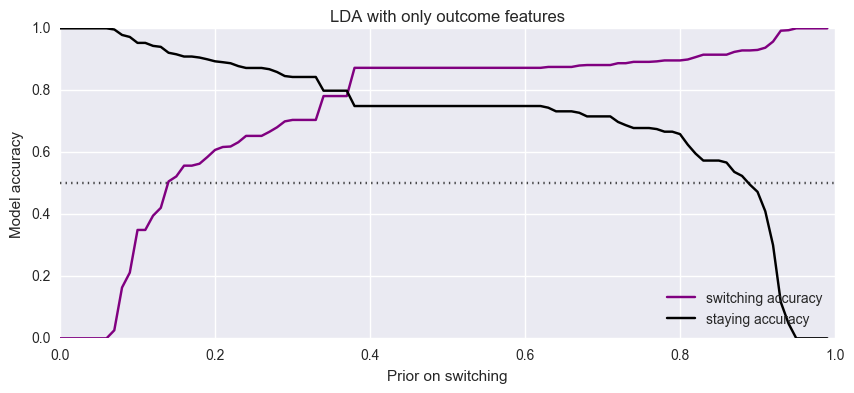

In [16]:
plt.figure(figsize=(10,4))
plt.plot(P,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(P,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
plt.legend(loc='lower right',bbox_to_anchor=[1,0])
plt.xlim(0,1)
plt.xlabel('Prior on switching')
plt.ylabel('Model accuracy')
plt.title('LDA with only outcome features')

## Compare the outcome and timing models:

In [28]:
x_test_o = x_test[:,outcome_inds]
best_lda_outcome = discriminant_analysis.LinearDiscriminantAnalysis(priors=[0.65,0.35])
best_lda_outcome.fit(x_train_o,y_train)
y_predict = best_lda_outcome.predict(x_test_o)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)


          Predicted NO  Predicted YES
True NO         2619.0          543.0
True YES          47.0          189.0

F1: 0.390

Accuracy on class 0: 0.83
Accuracy on class 1: 0.80



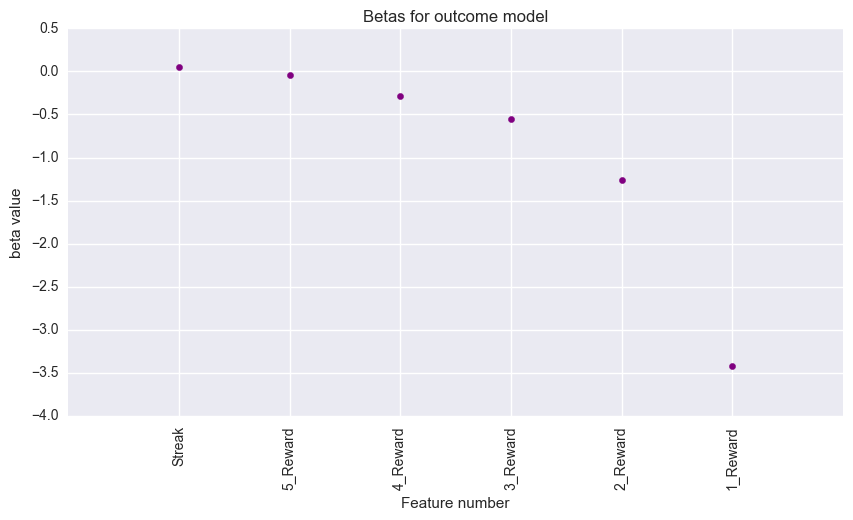

In [29]:
coefs = best_lda_outcome.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),outcome_features,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')
plt.title('Betas for outcome model')

In [30]:
x_test_t = x_test[:,timing_inds]
best_lda_timing = discriminant_analysis.LinearDiscriminantAnalysis(priors=[0.48,0.52])
best_lda_timing.fit(x_train_t,y_train)
y_predict = best_lda_timing.predict(x_test_t)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)


          Predicted NO  Predicted YES
True NO         1826.0         1336.0
True YES          82.0          154.0

F1: 0.178

Accuracy on class 0: 0.58
Accuracy on class 1: 0.65



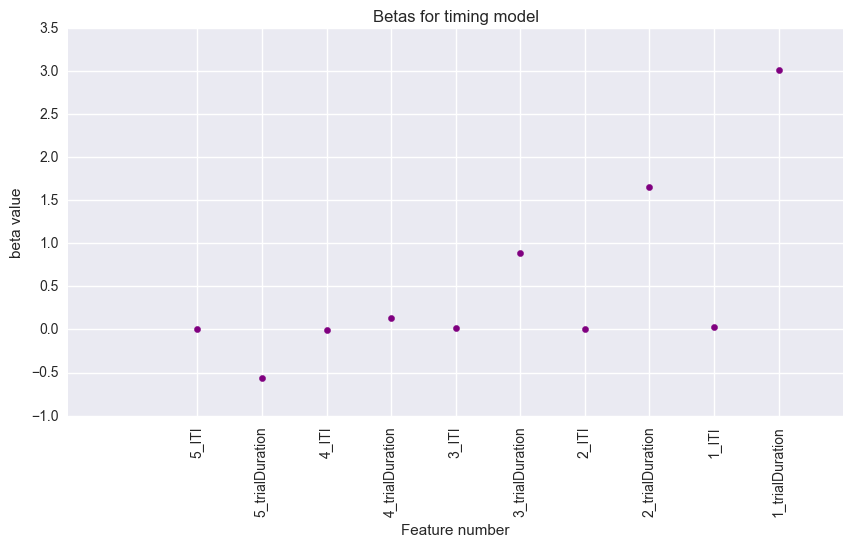

In [31]:
coefs = best_lda_timing.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),timing_features,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')
plt.title('Betas for timing model')

# Comparing 'short term' and 'long term' features

In [21]:
data.iloc[0,:]

Previous_10_Left_Choice     10.000
Previous_10_Right_Choice     0.000
Previous_10_Left_Reward      8.000
Previous_10_Right_Reward     0.000
Streak                      -1.000
5_Port                       1.000
5_Reward                     0.000
5_ITI                        3.286
5_trialDuration              0.407
4_Port                       1.000
4_Reward                     1.000
4_ITI                        2.405
4_trialDuration              0.463
3_Port                       1.000
3_Reward                     1.000
3_ITI                        2.379
3_trialDuration              0.367
2_Port                       1.000
2_Reward                     1.000
2_ITI                        2.234
2_trialDuration              0.325
1_Port                       1.000
1_Reward                     0.000
1_ITI                        2.133
1_trialDuration              0.482
0_ITI                        1.411
0_trialDuration              0.435
Decision                     1.000
Name: 0, dtype: floa

In [22]:
data.columns.values

array(['Previous_10_Left_Choice', 'Previous_10_Right_Choice',
       'Previous_10_Left_Reward', 'Previous_10_Right_Reward', 'Streak',
       '5_Port', '5_Reward', '5_ITI', '5_trialDuration', '4_Port',
       '4_Reward', '4_ITI', '4_trialDuration', '3_Port', '3_Reward',
       '3_ITI', '3_trialDuration', '2_Port', '2_Reward', '2_ITI',
       '2_trialDuration', '1_Port', '1_Reward', '1_ITI', '1_trialDuration',
       '0_ITI', '0_trialDuration', 'Decision'], dtype=object)

In [24]:
short_features = data.columns.values[6:-2]
long_features = data.columns.values[:6]
print(short_features)
print()
print(long_features)

['5_Reward' '5_ITI' '5_trialDuration' '4_Port' '4_Reward' '4_ITI'
 '4_trialDuration' '3_Port' '3_Reward' '3_ITI' '3_trialDuration' '2_Port'
 '2_Reward' '2_ITI' '2_trialDuration' '1_Port' '1_Reward' '1_ITI'
 '1_trialDuration' '0_ITI']
()
['Previous_10_Left_Choice' 'Previous_10_Right_Choice'
 'Previous_10_Left_Reward' 'Previous_10_Right_Reward' 'Streak' '5_Port']


In [25]:
#get column indices (so we can index from the numpy arrays)
short_inds = []
long_inds = []
for f in short_features:
    short_inds.append(data.columns.get_loc(f))
    
for f in long_features:
    long_inds.append(data.columns.get_loc(f))

In [34]:
'''
LDA
'''
lda_short = discriminant_analysis.LinearDiscriminantAnalysis(priors = [0.35,0.65])
lda_long = discriminant_analysis.LinearDiscriminantAnalysis(priors = [0.35,0.65])
lda_both = discriminant_analysis.LinearDiscriminantAnalysis(priors = [0.35,0.65])

lda_short.fit(x_train[:,short_inds],y_train)
lda_long.fit(x_train[:,long_inds],y_train)
lda_both.fit(x_train,y_train)

y_pred_short = lda_short.predict(x_test[:,short_inds])
y_pred_long = lda_long.predict(x_test[:,long_inds])
y_pred_both = lda_both.predict(x_test)

In [35]:
print('Short features:')
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_pred_short,y_test,disp=True,confusion=False)

print('Long features:')
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_pred_long,y_test,disp=True,confusion=False)

print('All features:')
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_pred_both,y_test,disp=True,confusion=False)

Short features:
          Predicted NO  Predicted YES
True NO         2367.0          795.0
True YES          19.0          217.0

F1: 0.348

Accuracy on class 0: 0.75
Accuracy on class 1: 0.92

Long features:
          Predicted NO  Predicted YES
True NO         1858.0         1304.0
True YES          17.0          219.0

F1: 0.249

Accuracy on class 0: 0.59
Accuracy on class 1: 0.93

All features:
          Predicted NO  Predicted YES
True NO         2409.0          753.0
True YES          18.0          218.0

F1: 0.361

Accuracy on class 0: 0.76
Accuracy on class 1: 0.92

